In [3]:
import time
import numpy as np
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


# Prediction Step
$x' = F \cdot x + u$

$P' = F \cdot P \cdot F^T + Q$

- $x$: State estimate
- $F$: State Transition Matrix
- $u$: motion vector
- $P$: Uncertainty Covariance
- $Q$: Process Noise

# Measurement Step

$y = z - H \cdot x$

$S = H \cdot P \cdot H^T + R$

$K = P \cdot H^T \cdot S^{-1} $

$x' = x + (K \cdot y) $

$P' = (I - K \cdot H) \cdot P $

- $y$: Residual Measurement uncertainty
- $S$: Covariance of residual
- $H$: Measurement function: Maps state space to measurement space
- $K$: Kalman Gain


Latex guide: https://ashki23.github.io/markdown-latex.html#:~:text=We%20can%20use%20LaTeX%20to,a%20double%20%24%20to%20display%20equations.


In [4]:
class EKF:
    '''Kalman filter class'''
    def __init__(self):
        self.dim_state = 4 # Process model dimension
        self.dt = 0.1 # Time Increment
        self.q = 0.1 # Process noise variable for Kalman Filter Q
    
    def F(self):
        '''
        State transition matrix
        '''
        dt = self.dt
        return np.matrix([  [1, 0, dt, 0],
                            [0, 1, 0, dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]) 

    def Q(self):
        '''
        Process noise covariance
        (Assumes noise through acceleration in x and y to be equal)
        '''
        q1 = (1/3)*(self.dt **3) * self.q
        q2 = (1/2)*(self.dt**2) * self.q
        q3 = (self.dt) * self.q
        
        #Q = Integrate(0, dt){ F(t) * Q * F(t)}
        return np.matrix([  [q1, 0, q2, 0], 
                            [0, q1, 0, q2],
                            [q2, 0, q3, 0],
                            [0, q2, 0, q3]])

    def H(self):
        # Jacobian H transforms from state space
        # to measurement space
        return np.matrix([ [1, 0, 0, 0],
                       [0, 1, 0, 0]])

    def predict(self, x, P):
        F = self.F()
        #Predict state estimation 
        x = F * x
        #Update error covariance matrix
        P = F* P *F.transpose() + self.Q() # covariance prediction
        return x, P

    def update(self, x, P, z, R):
        H = self.H()
        # update state and error covariance with associated measurement
        #1) Residual (The measurement uncertainty)
        gamma = z - H*x 
        #2) Covariance of residual 
        S = H * P * H.transpose() + R 
        #3) Kalman gain: Weighs the predicted state in comparison to the measurement 
        K = P * H.transpose() * np.linalg.inv(S)
        #3) Update the state
        x = x + K * gamma 
        #4) Update error covariance matrix
        I = np.identity(self.dim_state)
        P = (I - K*H) * P
        return x, P
    
        

$$ 
x = 
\begin{bmatrix}
x \\
y \\
\dot{x} \\
\dot{y}
\end{bmatrix}
$$

$$ 
p = 
\begin{bmatrix}
x_{err}^2 & 0 & 0 & 0 \\
0 & y_{err}^2 & 0 & 0\\
0 & 0 & \dot{x}_{err}^2 & 0\\
0 & 0 & 0 & \dot{y}_{err}^2
\end{bmatrix}
$$


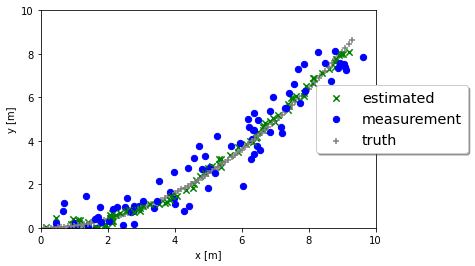

In [10]:
def run_filter():

    '''
    loop over data and call predict/update
    '''

    np.random.seed(0) 

    sigma_z = 0.5 # measurement noise 

    KF = EKF()

    fig, ax = plt.subplots()

    #init track state and covariance
    x = np.matrix( [[0],
                    [0],
                    [0],
                    [0]])

    P = np.matrix( [[0.1**2, 0,      0,      0],
                    [0,      0.1**2, 0,      0],
                    [0,      0,      2**2,   0],
                    [0,      0,      0,      2**2]])

    # loop over measurements and call predict and update
    for i in range(1,101):        
        
        # 1) Prediction Step
        x, P = KF.predict(x, P)

        # 2A) Ground truth generation
        truth = np.matrix([
            [i * KF.dt],
            [0.1 * (i * KF.dt)**2]
        ])

        # 2B) Measurement generation
        z = np.matrix([
            [float(truth[0]) + np.random.normal(0, sigma_z)],
            [float(truth[1]) + np.random.normal(0, sigma_z)] # generate noisy measurement
        ])
        R = np.matrix([
            [sigma_z**2, 0],# measurement noise covariance matrix
            [0, sigma_z**2]
        ])

        #3) Update
        x, P = KF.update(x, P, z, R)

        #Visualization
        ax.scatter(float(x[0]), float(x[1]), color='green', s=40, marker='x', label='estimated')
        ax.scatter(float(z[0]), float(z[1]), color='blue', s=40, marker='o', label='measurement')
        ax.scatter(float(truth[0]), float(truth[1]), color='gray', s=40, marker='+', label='truth')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)

        #Remove repeated labels
        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)

        ax.legend(handle_list, label_list, loc='center left', 
                    shadow=True, fontsize='x-large', bbox_to_anchor=(0.8, 0.5))

        try:
            plt.plot()
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)
        except KeyboardInterrupt:
            break

    #Display
    # plt.show()
        
run_filter()

        